In [169]:
import warnings
warnings.filterwarnings('ignore')

# Load NeuroKit and other useful packages
import os
#!pip install neurokit2
import neurokit2 as nk
import numpy as np
import pandas as pd
import scipy.stats as st
import scipy.signal as signal
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 6]  # Bigger images

# Load lists
from lists import dyads, num_dyads, participants, num_participants

conditions = ["sit","gaze","gaze_swap","sync"]

# Preprocess data

In [67]:
# Set sampling rate for neurokit2
sampling_rate = 2000

In [204]:
# Cosine interpolation
def cosine(x, x1, x2):
    from math import pi, cos
    T = x2-x1
    val = 0.5 * cos(2.0 * pi * (x - x1) / T)
    return val


def rpeaks_cosine_interpolation(rpeaks, noise_spread = 0):
    rpeaks_idx = [i for i, x in enumerate(rpeaks) if x == 1]
    num_rpeaks = len(rpeaks_idx)
    
    if noise_spread == 0: 
        noise = [0]*num_rpeaks
    elif noise_spread != 0:
        # Add noise
        # Generate normal distribution and round to whole numbers
        noise = np.round(np.random.normal(scale=noise_spread, size=num_rpeaks))
        # Search for sum = 0
        while sum(noise) != 0 or np.round(np.std(noise), 1) != noise_spread:
            noise = np.round(
                np.random.normal(
                    scale=noise_spread, 
                    size=num_rpeaks))
        # Convert to ints
        noise = [round(x) for x in noise]
        # Calculate average noise (%)
        # Get IBI
        ibi = [
            rpeaks_idx[s]-rpeaks_idx[s-1]
            for s in range(num_rpeaks)
            if s > 0
        ]
        noise_percentage = np.mean(abs(np.array(noise)))/np.mean(np.array(ibi))*100

    # Interpolation
    rpeaks_cip = [np.nan]*(rpeaks_idx[0]+noise[0])

    for i in range(num_rpeaks):
        if i == num_rpeaks-1:
            break
        x1 = rpeaks_idx[i]
        x2 = rpeaks_idx[i+1]
        T = x2-x1
        f = lambda x: cosine(x, x1, x2)
        # span interval with corresponding number of time steps + noise
        x = np.linspace(x1, x2, T+noise[i+1])
        y = [f(x) for x in x]
        rpeaks_cip = rpeaks_cip + y

    rpeaks_cip = rpeaks_cip + [np.nan]*(len(rpeaks)-rpeaks_idx[-1])

    # return rpeaks_cip, noise_percentage if 'noise_percentage' in locals() else pass
    # keep in mind: there are nans at the start and end
    if noise_spread != 0:
        return(rpeaks_cip, noise_percentage)
    else:
        return rpeaks_cip
    
# Pairwise swapping for permutated dyads
def swap_data(data, condition):
    def swappairwise(a): 
        # Based on https://stackoverflow.com/a/30132333
        l = len(a) & ~1
        a[1:l:2], a[:l:2] = a[:l:2], a[1:l:2]
    # Create new list
    a = list(range(len(data)))
    a.insert(0, a[-1])
    a.pop()
    
    swappairwise(a) # i.e. 1,2,3,4,5,6 -> 1,6,3,2,5,3,4
    # Iterate through new list
    data_swap = [None]*num_participants
    for i in list(range(len(data))):
        data_swap[i] = data[a[i]]
        data_swap[i] = np.array(data_swap[i], dtype="float32")
    data_swap = np.array(data_swap)
    # Save files
    np.save(f"data/data_{condition}.npy", data_swap)
    
    return data_swap

In [202]:
# Preprocess function
def preprocess(condition):
    ecg_raw = [None]*num_participants
    ecg = [None]*num_participants
    rpeaks = [None]*num_participants
    data = [None]*num_participants

    # Load data: raw ecgs for 300 s at 1000 Hz
    ecg_raw = np.load(f"data/ecg_raw/ecg_raw_{condition}.npy")

    for i in participants:
        ecg_raw[i] = pd.Series(ecg_raw[i].ravel()) # .ravel() to remove redundant parentheses
        # Clean and normalize data
        ecg[i] = nk.ecg_clean(
            ecg_raw[i], 
            sampling_rate=sampling_rate, 
            method="neurokit")
        # Get R-peaks as a binary time series
        rpeaks[i] = nk.ecg_peaks(
            ecg[i], 
            sampling_rate=sampling_rate)
        rpeaks[i] = rpeaks[i][0]["ECG_R_Peaks"]
        # Trigonometric interpolation of r-peaks
        data[i] = rpeaks_cosine_interpolation(rpeaks[i])
        # Trim data to get rid of nans
        data[i] = data[i][2*sampling_rate:300*sampling_rate-2*sampling_rate]
        # Downsampling to 50 Hz
        data[i] = data[i][::40]
        data[i] = np.array(data[i], dtype="float32")
    data = np.array(data)
    
    np.save(f"data/data_{condition}.npy", data)
    return data, ecg, rpeaks


# Add noise to GAZE
# Simulate synched data (SYNC)

def preprocess_with_noise(rpeaks, noise_spread):
    data, noise_percentage = rpeaks_cosine_interpolation(rpeaks, noise_spread)
    # Trim data to get rid of nans
    data = data[2*sampling_rate:300*sampling_rate-2*sampling_rate]
    # Downsampling to 50 Hz
    data = data[::40]
    data = np.array(data, dtype="float32")
    return data, noise_percentage


# Quality check
def quality_check(ecg):
    print("ECG quality:")
    for i in participants:
        quality = nk.ecg_quality(
            ecg[i], rpeaks=None, 
            sampling_rate=sampling_rate, 
            method="zhao2018", 
            approach="fuzzy")
        print(f"Person {i} | {quality}")

In [200]:
# Preprocess raw ECG data
ecg = {}
rpeaks = {}
data = {}
condition = ["sit","gaze"]

for con in condition:
    data[con], ecg[con], rpeaks[con] = preprocess(con)
    print(f"### {con.upper()} ###")
    print(f"Data shape:", data[con].shape)
    quality_check(ecg[con])
    

### SIT ###
Data shape: (8, 14800)
ECG quality:
Person 0 | Excellent
Person 1 | Barely acceptable
Person 2 | Excellent
Person 3 | Excellent
Person 4 | Excellent
Person 5 | Excellent
Person 6 | Barely acceptable
Person 7 | Excellent
### GAZE ###
Data shape: (8, 14800)
ECG quality:
Person 0 | Excellent
Person 1 | Excellent
Person 2 | Excellent
Person 3 | Excellent
Person 4 | Excellent
Person 5 | Excellent
Person 6 | Excellent
Person 7 | Excellent


In [201]:
# Create GAZE-SWAP
data["gaze_swap"] = swap_data(data["gaze"],"gaze_swap")
print("Data shape GAZE-SWAP:", data["gaze_swap"].shape)

# Sanity check for pairwise swapping
np.equal(
    data["gaze"],
    data["gaze_swap"])

Data shape GAZE-SWAP: (8, 14800)


array([[ True,  True,  True, ...,  True,  True,  True],
       [False, False, False, ..., False, False, False],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [False, False, False, ..., False, False, False],
       [ True,  True,  True, ...,  True,  True,  True],
       [False, False, False, ..., False, False, False]])

In [205]:
# Create list for indices with partners that did not
# take part in the experiment together
# with an equal gender distribution, e.g.:
# 0 1 2 3 4 5 6 7
# ->
# 0 3 4 7
sync_idx = sorted(
    [*participants[::4],
     *participants[3::4]])

data_sync = [None]*len(sync_idx)
noise_percentage = [None]*len(sync_idx)

for i, idx in enumerate(sync_idx):
    data_sync[i], noise_percentage[i] = preprocess_with_noise(
        rpeaks["gaze"][idx],
        noise_spread=50)

# Move data into a whole dataset
data["sync"] = [None]*(len(sync_idx)*2)
data["sync"][::2] = [
    data["gaze"][idx]
    for _, idx in enumerate(sync_idx)
]
data["sync"][1::2] = data_sync

# Save data
np.save(f"data/data_sync.npy", data["sync"])

print(
    f"Noise percentage:\
{[round(noise_percentage[i],2) for i in range(len(sync_idx))]} %,\
    \nMean: {np.mean(noise_percentage):.3} %,\
    \nSD: {np.std(noise_percentage):.3} %")

Noise percentage:[2.36, 2.19, 3.07, 2.39] %,    
Mean: 2.5 %,    
SD: 0.337 %


## Plot data

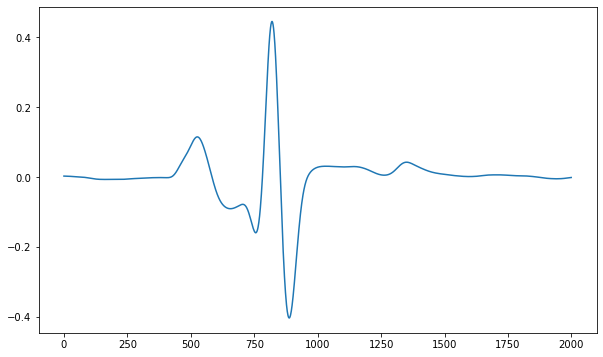

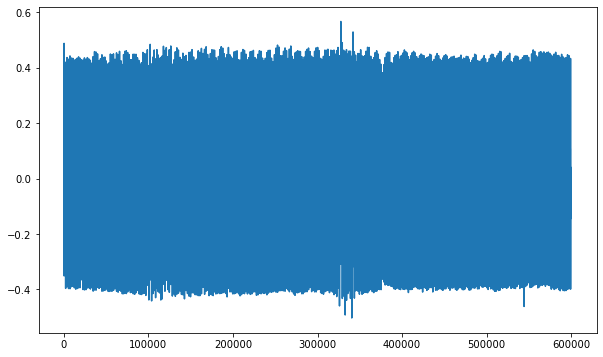

In [78]:
# Show sample data
plt.figure(1)
plt.plot(ecg["sit"][0][0:sampling_rate])

plt.figure(2)
plt.plot(ecg["gaze"][0])

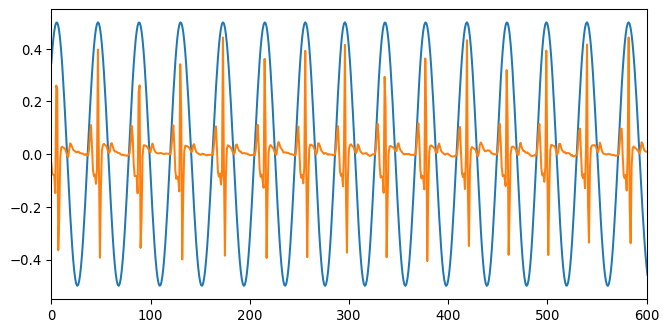

In [79]:
xlim1 = 0*sampling_rate/40
xlim2 = 24*sampling_rate/40

fig = plt.figure(figsize=(8,4), dpi=96)

plt.xlim(xlim1, xlim2/2)

plt.plot(data["sit"][0])
plt.plot(ecg["sit"][0][2*sampling_rate::40])

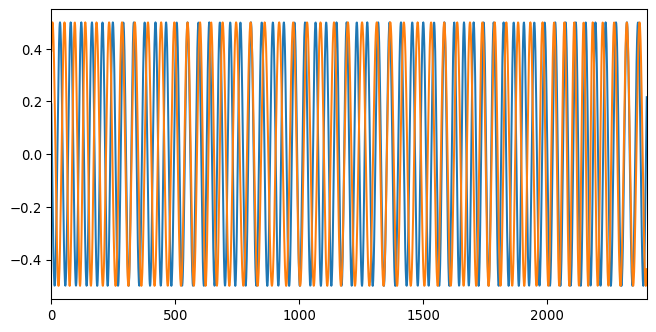

In [80]:
fig = plt.figure(figsize=(8,4), dpi=96)

plt.xlim(xlim1, xlim2*2)
test = np.array(data["gaze"][0])

plt.plot(data["gaze"][0])
plt.plot(data["gaze"][1])

(200.0, 300.0)

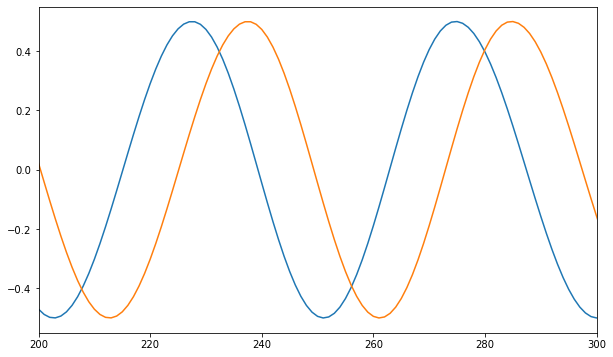

In [81]:
plt.plot(data["sit"][1][10:])
plt.plot(data["sit"][1][0:])

plt.xlim([200,300])

array([ True,  True,  True, ...,  True,  True,  True])

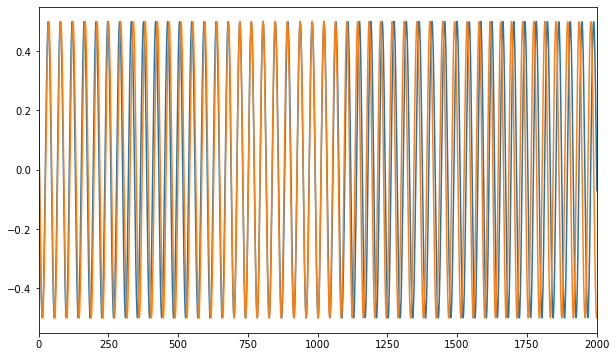

In [191]:
# Plot data & sanity check
plt.plot(data["sync"][0])
plt.plot(data["sync"][1])
plt.xlim(0,2000)
np.equal(data["gaze"][3], data["sync"][2])


In [182]:
np.corrcoef(data["sync"][0],data["sync"][1])[0,1]

0.295190044943304

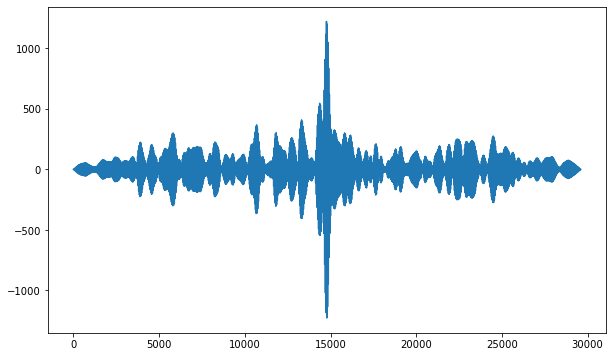

In [192]:
corr = signal.correlate(data["sync"][0],data["sync"][1])
plt.plot(corr)

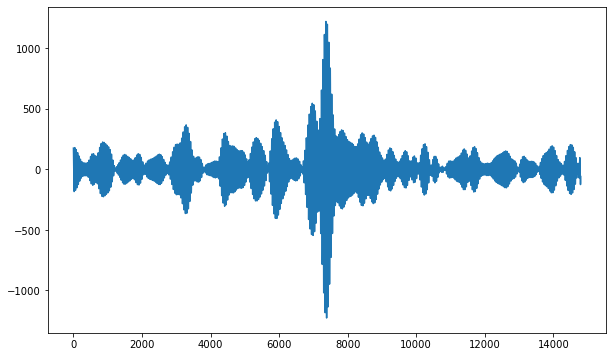

In [183]:
corr = np.correlate(data["sync"][0],data["sync"][1],"same")
plt.plot(corr)

In [ ]:
def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))

d1 = df['S1_Joy']
d2 = df['S2_Joy']
seconds = 5
fps = 30
rs = [crosscorr(d1,d2, lag) for lag in range(-int(seconds*fps),int(seconds*fps+1))]
offset = np.floor(len(rs)/2)-np.argmax(rs)
f,ax=plt.subplots(figsize=(14,3))
ax.plot(rs)
ax.axvline(np.ceil(len(rs)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(rs),color='r',linestyle='--',label='Peak synchrony')